In [58]:
import os
import xarray as xr
from eofs.xarray import Eof
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from cdo import Cdo
cdo = Cdo()

# Add directory to path
import sys
sys.path.append('/vortexfs1/home/kcarr/summer-project-2020/') 
from utils import stack_month_and_year, unstack_month_and_year, get_proj_xr
from preprocess import remove_season, get_trend_fast

cdo


In [3]:
scratch_dir = '/vortexfs1/scratch/kcarr'

class file_processor():
    def __init__(self, var_name, lon_range, lat_range):
        self.var_name = var_name
        self.lon_range = lon_range
        self.lat_range = lat_range
        return
    
    def trim_file(self, x):
        '''Function trims file according to lon/lat range'''
        f_in, f_out = x
        lon1, lon2 = self.lon_range
        lat1, lat2 = self.lat_range
        cdo.sellonlatbox(f'{lon1},{lon2},{lat1},{lat2}', 
                         input = f'-selvar,{self.var_name} '+ f_in, 
                         output = f_out)
        return

flut_proc = file_processor(var_name='FLUT', lon_range=(0,360), lat_range=(-15,15))
u200_proc = file_processor(var_name='U200', lon_range=(0,360), lat_range=(-15,15))
u850_proc = file_processor(var_name='U850', lon_range=(0,360), lat_range=(-15,15))
prect_proc = file_processor(var_name='PRECT', lon_range=(0,360), lat_range=(-15,15))
sst_proc = file_processor(var_name='SST', lon_range=(190,240), lat_range=(-5,5))

def get_files(var_name):
    '''Get input and output file names for given variable'''
    files = sorted(glob.glob(os.path.join(scratch_dir, f'*{var_name}*.nc')))
    files = [(f, f'{scratch_dir}/{var_name}_{f[53:56]}.nc') for f in files]
    return files        

flut_files = get_files('FLUT')
u200_files = get_files('U200')
u850_files = get_files('U850')
prect_files = get_files('PRECT')
sst_files = get_files('SST')

### Analyze single ensemble member

In [4]:
def regrid_sst(infile, outfile, res):
    '''Function regrids data in given model folder to global lonlat resolution given by res'''
    try:
        cdo.remapbil(res, input=f'-selname,SST {infile}', output=outfile)
    except CDOException:
        print(f'Cannot remap')
    return

In [5]:
out_file = os.path.join(scratch_dir, 'sst_regrid.nc')
regrid_sst(infile=sst_files[-1][0], outfile=out_file, res='r288x192')

cdo


In [66]:
sst = xr.open_dataset(out_file).SST.squeeze('z_t', drop=True)
sst = sst.sel(lat=slice(-5,5), lon=slice(190,240))

In [32]:
olr = xr.open_dataset(flut_files[-1][0]).FLUT
olr = olr.sel(lat=slice(-15,15))

u200 = xr.open_dataset(u200_files[-1][0]).U200
u200 = u200.sel(lat=slice(-15,15))

u850 = xr.open_dataset(u850_files[-1][0]).U850
u850 = u850.sel(lat=slice(-15,15))

prect = xr.open_dataset(prect_files[-1][0]).PRECT
prect = prect.sel(lat = slice(25, 50), lon=slice(230,300))

#### Compute anomalies

In [124]:
# compute oceanic nino index (oni)
sst = sst - get_trend_fast(sst)
sst = remove_season(sst, standardize=False)[0]
oni = sst.mean(dim=['lon','lat']).rolling(time=3).mean()

# interpolate to daily
oni_daily = oni.interp(time=pd.date_range('1920-03-01', '2006-01-01', freq='D'))

# remove NaN values
oni_daily = oni_daily[~np.isnan(oni_daily)][:-1]

# remove leap days
oni_daily = oni_daily.sel(time=~((oni_daily.time.dt.month == 2) \
                                 & (oni_daily.time.dt.day==29)))

In [36]:
# Remove trend from (daily) atmospheric data
olr = olr - get_trend_fast(olr)
u200 = u200 - get_trend_fast(u200)
u850 = u850 - get_trend_fast(u850)
prect = prect-get_trend_fast(prect)

In [49]:
# remove seasonal cycle from atmos data
olr = olr.groupby('time.month') - olr.groupby('time.month').mean()
u200 = u200.groupby('time.month') - u200.groupby('time.month').mean()
u850 = u850.groupby('time.month') - u850.groupby('time.month').mean()
prect = prect.groupby('time.month') - prect.groupby('time.month').mean()

#### Remove ENSO variability from atmos data

In [143]:
# make sure dates align
u200 = u200.sel(time=slice('1920-04-02',None))
u850 = u850.sel(time=slice('1920-04-02',None))
olr = olr.sel(time=slice('1920-04-02',None))

# remove linear relationship with ENSO
u200 = u200 - get_proj_xr(oni_daily, u200)
u850 = u850 - get_proj_xr(oni_daily, u850)
olr = olr - get_proj_xr(oni_daily, olr)

In [158]:
# remove 120-day running mean
u200 = u200.isel(time=slice(119,None)) - \
        u200.rolling(time=120).mean().isel(time=slice(119,None))
u850 = u850.isel(time=slice(119,None)) - \
        u850.rolling(time=120).mean().isel(time=slice(119,None))
olr = olr.isel(time=slice(119,None)) - \
        olr.rolling(time=120).mean().isel(time=slice(119,None))

In [167]:
# Take latitudinal mean, and normalize by variance
u200 = u200.mean(dim='lat') / u200.std()
u850 = u850.mean(dim='lat') / u850.std()
olr = olr.mean(dim='lat') / olr.std()

In [183]:
mjo_data = xr.concat([u200, u850, olr], 
                     dim=pd.Index(['u200','u850','olr'],name='variable'))
mjo_data = mjo_data.transpose('time',...)
eof_obj = Eof(mjo_data) #### EOF analysis to get MJO index

## Plots

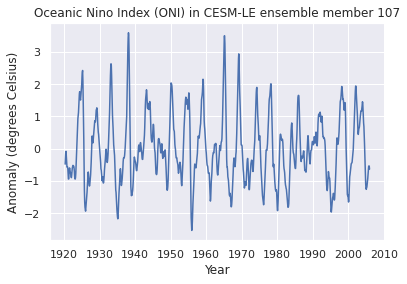

In [228]:
## plot ONI index
fig,ax = plt.subplots()
ax.plot(oni.time, oni)
ax.set_xlabel('Year')
ax.set_ylabel('Anomaly (degrees Celsius)')
ax.set_title('Oceanic Nino Index (ONI) in CESM-LE ensemble member 107')
plt.show()

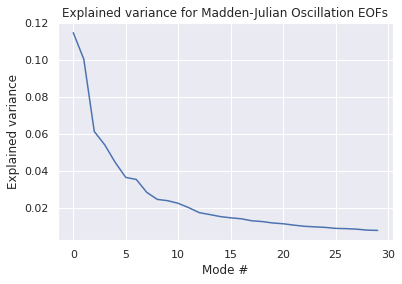

In [201]:
fig,ax=plt.subplots()
ax.plot(eof_obj.varianceFraction()[:30])
ax.set_ylabel('Explained variance')
ax.set_xlabel('Mode #')
ax.set_title('Explained variance for Madden-Julian Oscillation EOFs')
plt.show()

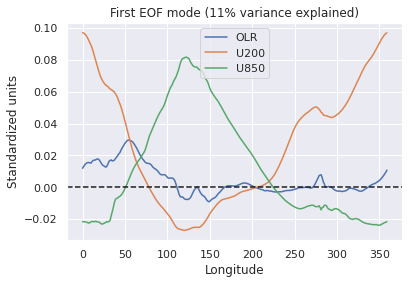

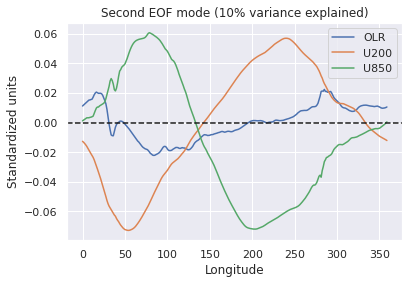

In [220]:
fig,ax=plt.subplots()
ax.plot(eof_obj.eofs().lon, eof_obj.eofs().sel(mode=0, variable='olr'), label='OLR')
ax.plot(eof_obj.eofs().lon, eof_obj.eofs().sel(mode=0, variable='u200'), label='U200')
ax.plot(eof_obj.eofs().lon, eof_obj.eofs().sel(mode=0, variable='u850'), label='U850')
ax.axhline(y=0, linestyle='--',color='k')
ax.set_xlabel('Longitude')
ax.set_ylabel('Standardized units')
ax.set_title('First EOF mode (11% variance explained)')
ax.legend()
plt.show()

fig,ax=plt.subplots()
ax.plot(eof_obj.eofs().lon, eof_obj.eofs().sel(mode=1, variable='olr'), label='OLR')
ax.plot(eof_obj.eofs().lon, eof_obj.eofs().sel(mode=1, variable='u200'), label='U200')
ax.plot(eof_obj.eofs().lon, eof_obj.eofs().sel(mode=1, variable='u850'), label='U850')
ax.axhline(y=0, linestyle='--',color='k')
ax.set_xlabel('Longitude')
ax.set_ylabel('Standardized units')
ax.set_title('Second EOF mode (10% variance explained)')
ax.legend()
plt.show()